The purpose of this notebook is to create a plot to display the ancestry breakdown for all of the DepMap cell lines

# Set up the environment

In [19]:
#Arguments/Parameters
working_dir = '/home/jupyter/notebooks/Ancestry' #home directory for this workspace
workspace_bucket = Sys.getenv('WORKSPACE_BUCKET') #the workspace bucket that we will upload the output to

In [20]:
#Load packages
library(tidyverse)
library(reshape2)


#Define functions
show_msg <- function(x){ 
    print(x)
    flush.console()
}

# Load in and format the data

The admixture output does not manually assign ancestry groups to the dataframe. So we need to inspect the output from the training set to manually assign ancestries to the columns

In [21]:
#Load in the ADMIXTURE training output
paste({working_dir}, "/admixture", sep = "") %>% setwd()
reference.set = read.table('merged.1kg.admixture.reference.5.Q', sep = " ") 


#Load in the sample annotation file
paste({working_dir}, "/admixture", sep = "") %>% setwd()
reference.annotation = read.table('merged.1kg.admixture.reference.pop', sep = "\t") %>%
pull(1)


#Calculate which column belongs to which ancestry group
reference.set %>%
mutate(ancestry = reference.annotation) %>%
group_by(ancestry) %>%
summarise(across(1:5, mean)) %>%
head()

ancestry,V1,V2,V3,V4,V5
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
AFR,0.00001,0.00001,0.00001,0.00001,0.99996
AMR,0.00001,0.00001,0.99996,0.00001,0.00001
EAS,0.00001,0.99996,0.00001,0.00001,0.00001
EUR,0.99996,0.00001,0.00001,0.00001,0.00001
SAS,0.00001,0.00001,0.00001,0.99996,0.00001


Now it's time to load in the ADMIXTURE output for the DepMap lines.

First, get all of the sample names.

In [22]:
#Get the sample names since they are not included in the ADMIXTURE output
system(glue::glue("
cd {working_dir}/admixture
{working_dir}/software/bcftools/bcftools query -l merged.ccle.admixture.target.vcf.gz > admixture.sample.header.for.plot
"))

#Load in the sample names
paste({working_dir}, "/admixture", sep = "") %>% setwd()
sample.names = read.table('admixture.sample.header.for.plot', sep = "\t") %>%
pull(1)

Load in the sample annotation data so that we can figure out which subtype each cell line belongs to.

In [23]:
#Download the sample annotation file
system(glue::glue("
cd {working_dir}/admixture
gsutil cp gs://fc-45c0e148-0b1c-4244-9bfc-feb559bbc514/internal-21q3_v15-sample-info.csv .
"))

#Load it into R
paste({working_dir}, "/admixture", sep = "") %>% setwd()
lineage.annotation = read.table('internal-21q3_v15-sample-info.csv', sep = ",", header = T) %>%
rename("depmap_id" = 1, "lineage" = 2)

head(lineage.annotation)

,depmap_id,lineage
,<chr>,<chr>
1,ACH-000001,ovary
2,ACH-000002,blood
3,ACH-000003,colorectal
4,ACH-000004,blood
5,ACH-000005,blood
6,ACH-000006,blood


Load in the ADMIXTURE data for the CCLE projections. Then format it to include the extra columns, column names, etc.

In [26]:
#Load in the CCLE Projections
paste({working_dir}, "/admixture", sep = "") %>% setwd()
ccle.projections = read.table('merged.ccle.admixture.target.5.Q', sep = " ") %>%
mutate(depmap_id = sample.names) %>%
rename("EUR" = 1, "EAS" = 2, "AMR" = 3, "SAS" = 4, "AFR" = 5) %>% #These names are based on the assignments from the reference
mutate(lineage = depmap_id) %>%
mutate(lineage = plyr::mapvalues(lineage, from = lineage.annotation$depmap_id, to = lineage.annotation$lineage, warn_missing = FALSE))

#Print the head so that we can take a look at it.
head(ccle.projections)

#Now write it out so that we can use it in downstream analysis
ccle.projections.for.export = ccle.projections %>%
rename("DepMap_ID" = depmap_id) %>%
rename("lineage_subtype" = lineage)


write.table(ccle.projections.for.export, "ccle.projections.txt", sep = "\t", col.names = T, row.names = F, quote = FALSE)

,EUR,EAS,AMR,SAS,AFR,depmap_id,lineage
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
1,0.058376,0.841298,0.028906,0.013521,0.057898,ACH-000380,plasma_cell
2,0.036494,0.863657,0.032450,0.008646,0.058753,ACH-000321,blood
3,0.011415,0.010345,0.003088,0.964387,0.010765,ACH-000857,breast
4,0.888580,0.017735,0.028750,0.055862,0.009074,ACH-000883,central_nervous_system
5,0.898368,0.014906,0.025614,0.052141,0.008971,ACH-000936,ovary
6,0.915203,0.006926,0.029091,0.026713,0.022068,ACH-000290,lung


,EUR,EAS,AMR,SAS,AFR,DepMap_ID,lineage_subtype
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
1,0.058376,0.841298,0.028906,0.013521,0.057898,ACH-000380,plasma_cell
2,0.036494,0.863657,0.032450,0.008646,0.058753,ACH-000321,blood
3,0.011415,0.010345,0.003088,0.964387,0.010765,ACH-000857,breast
4,0.888580,0.017735,0.028750,0.055862,0.009074,ACH-000883,central_nervous_system
5,0.898368,0.014906,0.025614,0.052141,0.008971,ACH-000936,ovary
6,0.915203,0.006926,0.029091,0.026713,0.022068,ACH-000290,lung


# Generate the plot

First, let's just try grouping them together by cancer type and taking the straight average.

In [7]:
#Group by lineage and take the average for each ancestry group
lineage.average = ccle.projections %>%
group_by(lineage) %>%
summarise(across(1:5, mean))


#Calculate the maximum ancestry for each cell line
max.ancestry = ccle.projections %>%
mutate(popmax = case_when(
                                EUR >= 0.8 ~ "European (EUR)",
                                EAS >= 0.8 ~ "East Asian (EAS)",
                                AMR >= 0.8 ~ "American (AMR)",
                                SAS >= 0.8 ~ "South Asian (SAS)",
                                AFR >= 0.8 ~ "African (AFR)")) %>%
mutate(popmax = replace_na(popmax, "Admixed")) %>%
select(depmap_id, lineage, popmax) %>%
group_by(lineage) %>%
count(popmax, .drop = FALSE) %>%
arrange(lineage)
head(max.ancestry)
write.table(max.ancestry, "ancestry.by.cancer.type.txt", sep = "\t", col.names = T, row.names = FALSE)



#Count the number of cell line for each lineage
num.lines = ccle.projections %>%
group_by(lineage) %>%
summarise(n()) %>%
rename("n" = 2) %>%
arrange(-n)
head(num.lines)

lineage,popmax,n
<chr>,<chr>,<int>
bile_duct,East Asian (EAS),7
blood,Admixed,13
blood,East Asian (EAS),19
blood,European (EUR),17
bone,East Asian (EAS),1
bone,European (EUR),4


lineage,n
<chr>,<int>
lung,120
blood,49
breast,42
ovary,36
colorectal,35
gastric,34


Plot the data with ggplot

In [8]:
num.lines$lineage %>% unique()

[1] "lung"                      "blood"                    
 [3] "breast"                    "ovary"                    
 [5] "colorectal"                "gastric"                  
 [7] "skin"                      "lymphocyte"               
 [9] "fibroblast"                "pancreas"                 
[11] "central_nervous_system"    "uterus"                   
[13] "upper_aerodigestive"       "plasma_cell"              
[15] "liver"                     "kidney"                   
[17] "urinary_tract"             "esophagus"                
[19] "bile_duct"                 "peripheral_nervous_system"
[21] "soft_tissue"               "prostate"                 
[23] "bone"                      "thyroid"

In [9]:
#Create a mapping file to adjust the text labels for all of the cancer lineages 
old.names = num.lines %>%
pull(lineage) %>%
unique()

new.names = c("Lung", "Blood", "Breast", "Ovarian", "Colorectal", "Gastric", "Skin", "Lymphocyte", "Fibroblast", "Pancreas", "CNS", "Uterus", "Upper Aerodigestive", "Plasma Cell", "Liver", "Kidney", "Urunary Tract", "Esophagus", "Bile Duct", "Peripheral Nervous System", "Soft Tissue", "Prostate", "Bone", "Thyroid")

mapping = cbind(old.names, new.names) %>%
data.frame()

Using lineage, popmax as id variables

Saving 10 x 6.67 in image



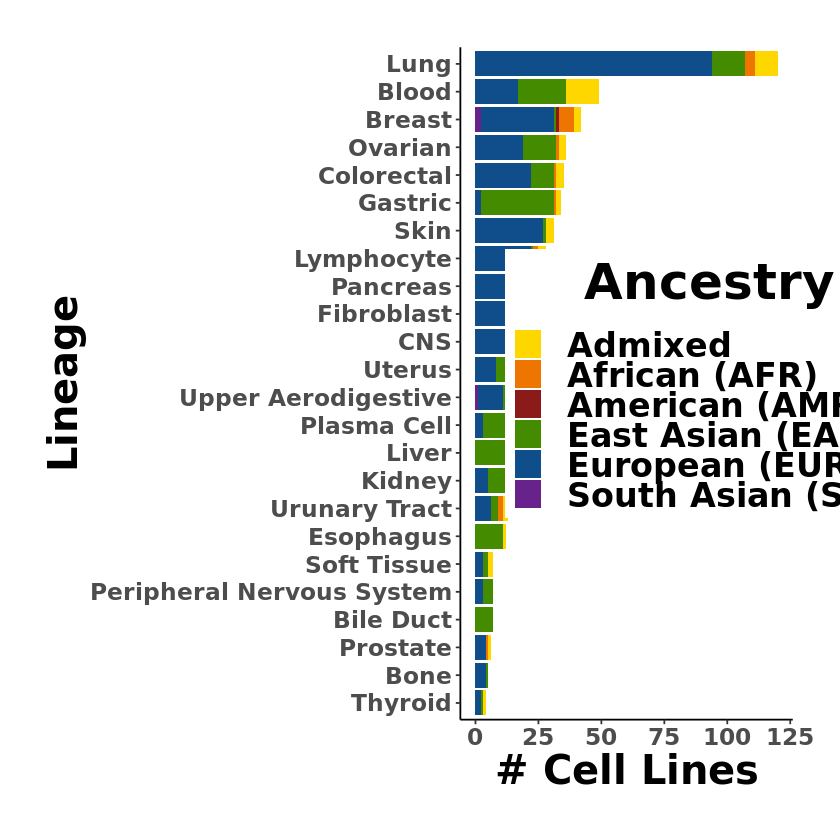

In [18]:
#Plot the data
max.ancestry %>%
select(sort(colnames(.))) %>%
melt() %>%
rename("lineage" = 1, "Ancestry" = 2, "fraction" = 4) %>%
select(lineage, Ancestry, fraction) %>%
mutate(lineage = as.factor(lineage)) %>%
mutate(lineage = plyr::mapvalues(lineage, from = mapping$old.names, to = mapping$new.names, warn_missing = FALSE)) %>%


ggplot() +
geom_bar(aes(x = fraction, y = reorder(lineage, fraction, sum), fill = Ancestry), stat="identity") +


scale_fill_manual(values = c("gold", "darkorange2", "firebrick4", "chartreuse4", "dodgerblue4", "darkorchid4")) +
theme_bw() +


theme(
panel.border = element_blank(), panel.grid.major = element_blank(),
panel.grid.minor = element_blank(), axis.line = element_line(colour = "black")
) +


theme(
axis.text=element_text(size=12),
axis.title=element_text(size=14, face="bold")
) +

theme(
axis.text.x = element_text(face="bold", size=14),
axis.text.y = element_text(face="bold", size=14)
) +

theme(
panel.border = element_blank(), panel.grid.major = element_blank(),
panel.grid.minor = element_blank(), axis.line = element_line(color = "black")
) +

theme(
legend.title = element_text(size = 14, face = "bold"),
legend.text = element_text(size = 10, face = "bold")
) +


theme(
legend.title.align=0.5
) +

theme(
strip.text = element_text(size = 8, face = "bold"),
strip.background = element_blank()
) +

xlab("# Cell Lines") +
ylab ("Lineage") +

theme(
axis.title=element_text(size = 24,face = "bold")
) +

theme(
plot.title = element_text(size = 20, face = "bold"),
legend.title=element_text(size=30), 
legend.text=element_text(size=20)
) +

theme(
legend.position = c(0.75, 0.5)
) +

theme(
plot.margin = unit(c(1,1,1,1), "cm")
)

#Save the plot
paste({working_dir}, "/figures", sep = "") %>% setwd()
ggsave("ancestry_bar_plot.png", width = 10, dpi = 700)

#Export it to the google bucket
system(glue::glue("
cd {working_dir}/figures
gsutil cp ancestry_bar_plot.png gs://fc-45c0e148-0b1c-4244-9bfc-feb559bbc514
"))